In [1]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm

# 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False


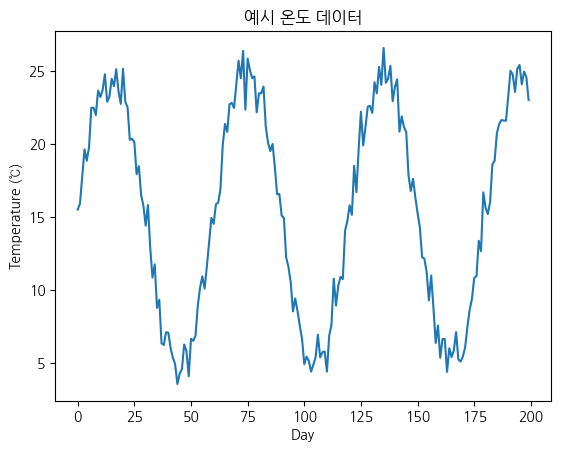

Epoch 1: Loss=98.7833
Epoch 20: Loss=1.4792
Epoch 40: Loss=1.7047
Epoch 60: Loss=1.6356
Epoch 80: Loss=1.3738
Epoch 100: Loss=1.6796


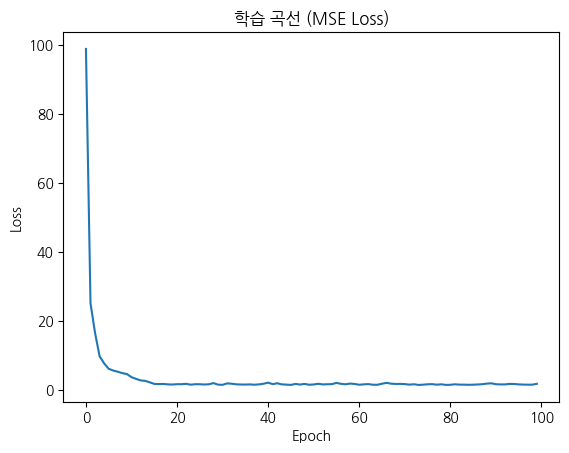

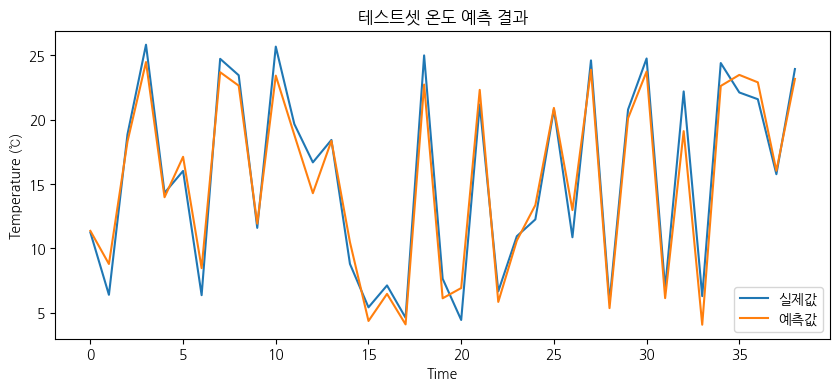


최근 7일 온도: [23.53573723 25.11839988 25.38531738 24.06136152 24.93520111 24.56877388
 22.99248428]
내일 예상 온도 예측: 23.3647403717041


/tmp/ipython-input-3-2925872657.py:100: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  x = torch.tensor([recent_temps], dtype=torch.float32)


In [3]:

# 1. 인공 온도 데이터 생성 (예: 200일치, 계절 변화+잡음)
np.random.seed(42)
days = np.arange(200)
temps = 15 + 10*np.sin(2*np.pi*days/60) + np.random.randn(200)  # 계절+잡음

plt.plot(days, temps)
plt.title("예시 온도 데이터")
plt.xlabel("Day")
plt.ylabel("Temperature (℃)")
plt.show()

# 2. (특성) n일치 온도 → (레이블) 다음날 온도 예측 데이터셋 준비
def create_dataset(series, n_steps=7):
    X, y = [], []
    for i in range(len(series)-n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    return np.array(X), np.array(y)
n_steps = 7
X, y = create_dataset(temps, n_steps=n_steps)

# 3. PyTorch Dataset 정의
class TempDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1,1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = TempDataset(X, y)
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 4. 간단 딥러닝 모델(MLP)
class TempPredictor(nn.Module):
    def __init__(self, n_steps):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_steps, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.net(x)

model = TempPredictor(n_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# 5. 학습
epochs = 100
losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        out = model(x_batch)
        loss = criterion(out, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss/len(train_loader))
    if (epoch+1)%20 == 0 or epoch==0:
        print(f"Epoch {epoch+1}: Loss={epoch_loss/len(train_loader):.4f}")

# 6. 학습 곡선 시각화
plt.plot(losses)
plt.title("학습 곡선 (MSE Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# 7. 테스트셋 예측 및 시각화
model.eval()
preds, trues = [], []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        pred = model(x_batch).item()
        preds.append(pred)
        trues.append(y_batch.item())

plt.figure(figsize=(10,4))
plt.plot(trues, label="실제값")
plt.plot(preds, label="예측값")
plt.legend()
plt.title("테스트셋 온도 예측 결과")
plt.xlabel("Time")
plt.ylabel("Temperature (℃)")
plt.show()

# 8. 예측 함수(최근 n일 온도로 내일 예측)
def predict_next_temps(recent_temps):
    x = torch.tensor([recent_temps], dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        pred = model(x).item()
    return pred

# 사용 예시
print("\n최근 7일 온도:", temps[-7:])
print("내일 예상 온도 예측:", predict_next_temps(temps[-7:]))
